# This notebook is to run HDID mouse RNA + network through the ASSIST workflow part 2 (ML + feature extraction + critical gene identification)

In [3]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
import seaborn as sns
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.models.feature_extraction import *
from src.models.ML_functions import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

# Preprocessing steps

In [11]:
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')

# Load embedding dfs

### Docker Machine learning & critical gene identifier

In [12]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Jan25/'
emb_list = []
embedding_names = []
for file in os.listdir(embedding_path):
    emb = pd.read_csv(embedding_path + file, index_col = 0)
    emb_list.append(emb)
    emb_name = '_'.join(file.split('_')[-4:-1])
    embedding_names.append(emb_name)

Wall time: 286 ms


In [14]:
%%time
# process embedding to be ready for ML
processed_emb_dfs = []
for emb in emb_list:
    processed_emb_dfs.append(process_emb_for_ML(emb, deseq = de_data))

Wall time: 38 ms


# Run ML on each embedding (3 embedding total), 3 models each and each model was repeated 3 times so a total of 3 x 3 x 3 = 27 results

### Docker Machine learning & critical gene identifier

lr average: 83.67 ;  rf average: 85.0 ;  xgb_average: 86.33
Removing existing folder: output
Created folder output


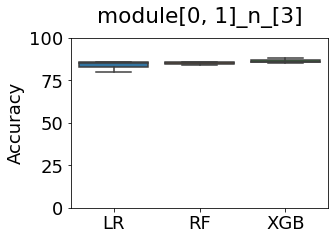

lr average: 85.67 ;  rf average: 88.67 ;  xgb_average: 87.33


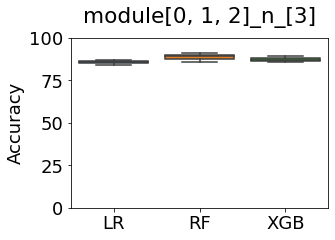

lr average: 87.67 ;  rf average: 87.0 ;  xgb_average: 87.33


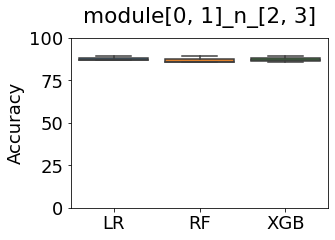

In [15]:
model_weight_list = []
for i, processed_df in enumerate(processed_emb_dfs):
    model_weight_list.append(run_ml(processed_df, emb_name = embedding_names[i], max_iter = 2000, print_accuracy = True))

# Getting the feature importances and the dimensions that make up 50% of feature importances

### Docker Machine learning & critical gene identifier

In [72]:
top_dim_list = []
for model_weights in model_weight_list:
    top_dim = plot_feature_importances(model_weights, top_n_coef = 0.5, print_num_dim = False, plot_heatmap = False, return_top_dim = True)
    top_dim_list.append(top_dim)

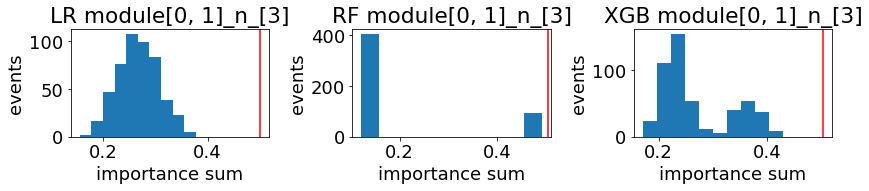

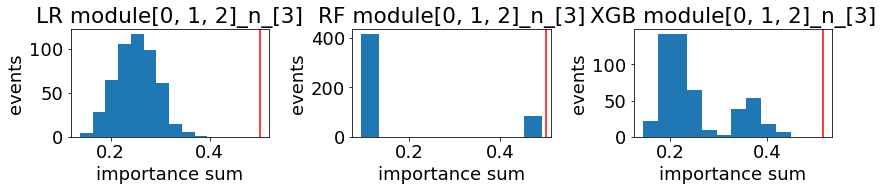

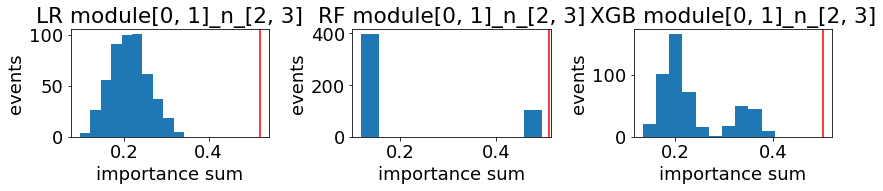

In [73]:
# The blue bars are the feature importance sum from random selection of the dimensions
# The red vertical line is the actual feature importance sum selected by ML
# Note each model was repeated 3 times but only 1 was shown
for i in range(len(model_weight_list)):
    plot_random_feature_importance(model_weight_list[i], top_dim_list[i], embedding_names[i])

## Determine jaccard similarity between the "important dimensions" for the repeats of the model

### Docker Machine learning & critical gene identifier

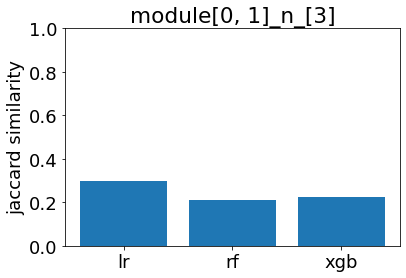

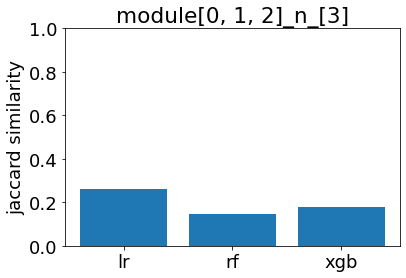

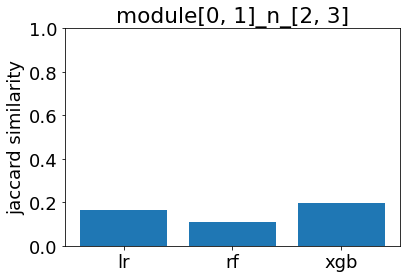

In [74]:
for i, top_dim in enumerate(top_dim_list):
    jaccard_average(top_dim, embedding_names[i])

# Identify critical genes from the parameters used (3 embeddings, 3 models, 3 repeats)

### Docker Machine learning & critical gene identifier

In [75]:
output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/feature_extraction_derived/'

# New codes

In [129]:
# The cutoff for impact genes for finding critical genes was 0.2 previously, ~ 0.004 of the total data
# Apply the same logic to find the cutoff value to call an impact gene
cutoff = de_data['abs_log2FC'].sort_values(ascending = False)[int(len(de_data) * 0.004)]

In [130]:
%%time
critical_gene_sets = []
critical_gene_dfs = []
for i, processed_df in enumerate(processed_emb_dfs):
    gene_set = get_critical_gene_sets(processed_df, top_dim_list[i], cutoff = cutoff, max_dist = 0.55)
    critical_gene_sets.append(gene_set)
    critical_gene_dfs.append(get_critical_gene_df(gene_set, embedding_names[i], output_dir))

Wall time: 1min 27s


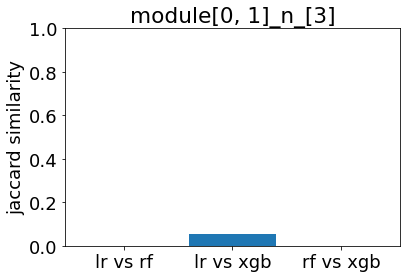

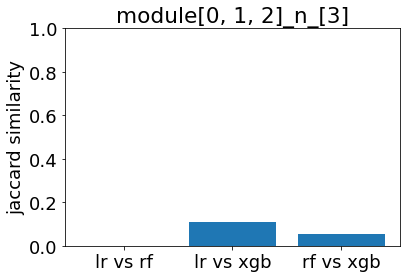

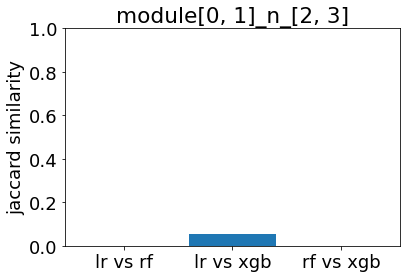

In [131]:
intersect_gene_list = []
for i, critical_gene_df in enumerate(critical_gene_dfs):
    intersect_genes = jaccard_critical_genes(critical_gene_df, embedding_names[i])
    intersect_gene_list.append(intersect_genes)

## Plot correlation of sets of critical genes found in common in 3 models for each embedding

### Module DE/ Diagnostic Correlation (second one)

In [ ]:
# skipped
# expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)
# gene_set_phenotype_corr(intersect_gene_list, embedding_names, expression_meta_df, 'intersect genes between 3 models')

## Plot number of nearby impact genes to the critical genes. 1 figure per embedding

### Docker Machine learning & critical gene identifier

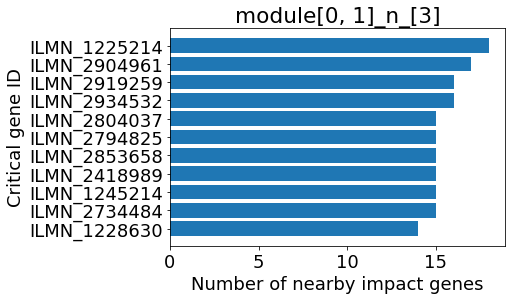

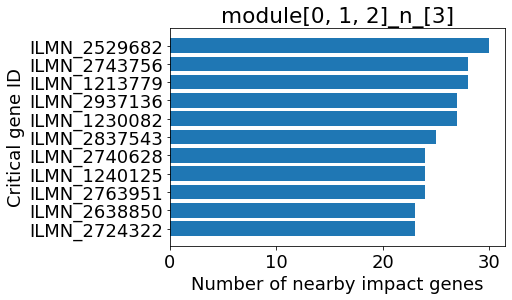

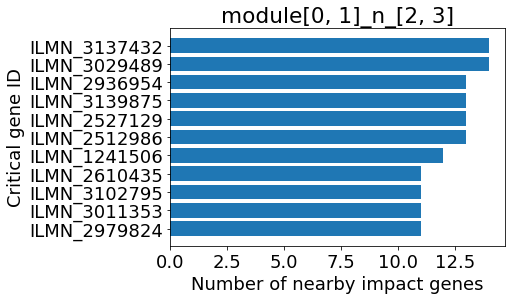

In [132]:
# critical_gene_sets2 is different from critical_gene_sets in that it only has # of nearby DEGs to the critical genes and is a complete list. 
# critical_gene_sets2 only has gene IDs and only has the top 10 genes
critical_gene_sets2 = []
for i, critical_gene_df in enumerate(critical_gene_dfs):
    gene_set = plot_nearby_impact_num(critical_gene_df, embedding_names[i])
    critical_gene_sets2.append(gene_set)

## Plot each set of critical genes and their correlation with alcohol traits. Each gene set is from 1 embedding

### Module DE/ Diagnostic Correlation (second one)

In [ ]:
# skipped
# Plot correlation of top critical genes (with most nearby impact genes) for each embedding
# gene_set_phenotype_corr(critical_gene_sets2, embedding_names, expression_meta_df, 'top 10 genes')

## Ignore the codes below. These are to convert gene names from Illumina tags to gene symbols. They're not meant to be in any module. 

In [7]:
de_data = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\de_data.csv')

In [5]:
critical_gene_path = r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\feature_extraction_derived'
critical_gene_dfs = []
for file in os.listdir(critical_gene_path):
    df = pd.read_csv(critical_gene_path + '/' + file)
    critical_gene_dfs.append(df)

In [13]:
gene_mapping_dict = pd.Series(de_data['gene'].values, index = de_data['id']).to_dict()

In [19]:
critical_genes = []
for df in critical_gene_dfs:
    critical_genes.append(df['gene'][:10].map(gene_mapping_dict))

In [ ]:
critical_genes = pd.concat(critical_genes).reset_index()